In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from datetime import datetime
import numpy as np

# Load the data
df = pd.read_csv("data/every_map.csv")

# Helper: extract clean team name (no parentheses)
def clean_name(name_with_score):
    return re.sub(r'\s*\(.*?\)', '', name_with_score)

# Clean names
df["Team1_Clean"] = df["Team1_Text"].apply(clean_name)
df["Team2_Clean"] = df["Team2_Text"].apply(clean_name)

# Convert date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Iterate over years
for year in range(2012, 2026):
    df_range = df[(df["Date"].dt.year >= year) & (df["Date"].dt.year <= year)]
    map_pool = set(df_range["Map_Name"].to_list())

    for map_name in map_pool:
        map_range = df_range[df_range["Map_Name"] == map_name]
        
        # Skip if data is too sparse
        if map_range.empty or map_range.shape[0] < 3:
            continue

        # Create a weighted undirected graph
        G = nx.Graph()

        for _, row in map_range.iterrows():
            t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
            r1, r2 = row["Team1_Score"], row["Team2_Score"]

            # Make sure scores are valid numbers
            if pd.isna(r1) or pd.isna(r2):
                continue

            try:
                r1 = int(r1)
                r2 = int(r2)
            except:
                continue

            # Calculate normalized margin
            total = r1 + r2
            if total == 0:
                continue
            margin = abs(r1 - r2) / total

            # Add edge (always between t1 and t2)
            if G.has_edge(t1, t2):
                G[t1][t2]['weight_sum'] += margin
                G[t1][t2]['count'] += 1
            else:
                G.add_edge(t1, t2, weight_sum=margin, count=1)

        # Average out the edge weights
        for u, v, data in G.edges(data=True):
            data['weight'] = data['weight_sum'] / data['count']

        # Find the biggest clique
        cliques = list(nx.find_cliques(G))
        max_clique = max(cliques, key=len)

        # Get average weight within the clique
        subG = G.subgraph(max_clique)
        edge_weights = [d['weight'] for _, _, d in subG.edges(data=True)]
        avg_weight = np.mean(edge_weights) if edge_weights else 0

        # Print results
        print(f"{year} | {map_name} | Max clique size: {len(max_clique)} | Avg weight: {avg_weight:.3f}")


2012 | Inferno_se | Max clique size: 4 | Avg weight: 0.290
2012 | Train_se | Max clique size: 2 | Avg weight: 0.333
2012 | Nuke_se | Max clique size: 3 | Avg weight: 0.347
2012 | Dust2_se | Max clique size: 3 | Avg weight: 0.523
2012 | Mirage_ce | Max clique size: 3 | Avg weight: 0.117
2013 | Train | Max clique size: 2 | Avg weight: 0.143
2013 | Mirage | Max clique size: 3 | Avg weight: 0.277
2013 | Inferno_se | Max clique size: 4 | Avg weight: 0.301
2013 | Cache | Max clique size: 2 | Avg weight: 0.231
2013 | Train_se | Max clique size: 4 | Avg weight: 0.426
2013 | Nuke | Max clique size: 3 | Avg weight: 0.527
2013 | Inferno | Max clique size: 3 | Avg weight: 0.141
2013 | Nuke_se | Max clique size: 4 | Avg weight: 0.279
2013 | Dust2 | Max clique size: 3 | Avg weight: 0.208
2013 | Dust2_se | Max clique size: 5 | Avg weight: 0.292
2013 | Mill_ce | Max clique size: 2 | Avg weight: 0.455
2013 | Mirage_ce | Max clique size: 4 | Avg weight: 0.286
2014 | Train | Max clique size: 3 | Avg weig

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_map_graph(df, year, map_name, highlight_clique=True):
    # Filter for the year and map
    df_range = df[(df["Date"].dt.year == year) & (df["Map_Name"] == map_name)]

    # Create graph
    G = nx.Graph()
    team_play_count = defaultdict(int)

    for _, row in df_range.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        r1, r2 = row["Team1_Score"], row["Team2_Score"]

        if pd.isna(r1) or pd.isna(r2):
            continue
        try:
            r1, r2 = int(r1), int(r2)
        except:
            continue
        total = r1 + r2
        if total == 0:
            continue
        margin = abs(r1 - r2) / total

        # Count appearances
        team_play_count[t1] += 1
        team_play_count[t2] += 1

        if G.has_edge(t1, t2):
            G[t1][t2]['weight_sum'] += margin
            G[t1][t2]['count'] += 1
        else:
            G.add_edge(t1, t2, weight_sum=margin, count=1)

    # Finalize weights
    for u, v, data in G.edges(data=True):
        data['weight'] = data['weight_sum'] / data['count']

    # Find largest clique (optional)
    max_clique = []
    if highlight_clique:
        cliques = list(nx.find_cliques(G))
        max_clique = max(cliques, key=len) if cliques else []

    # Node properties
    degrees = dict(G.degree())
    node_sizes = [300 + 50 * team_play_count.get(n, 1) for n in G.nodes()]
    node_colors = ['red' if n in max_clique else 'skyblue' for n in G.nodes()]

    # Edge properties
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    edge_widths = [2 + 5 * w for w in edge_weights]
    edge_colors = [plt.cm.viridis(w) for w in edge_weights]

    # Layout
    pos = nx.fruchterman_reingold_layout(G, k=1.2, seed=420)

    # Plot
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.7)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title(f"{map_name} Map Graph ({year})", fontsize=16)
    plt.axis('off')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    # cbar = plt.colorbar(sm)
    # cbar.set_label('Edge Weight (Normalized Round Margin)', fontsize=12)
    plt.show()


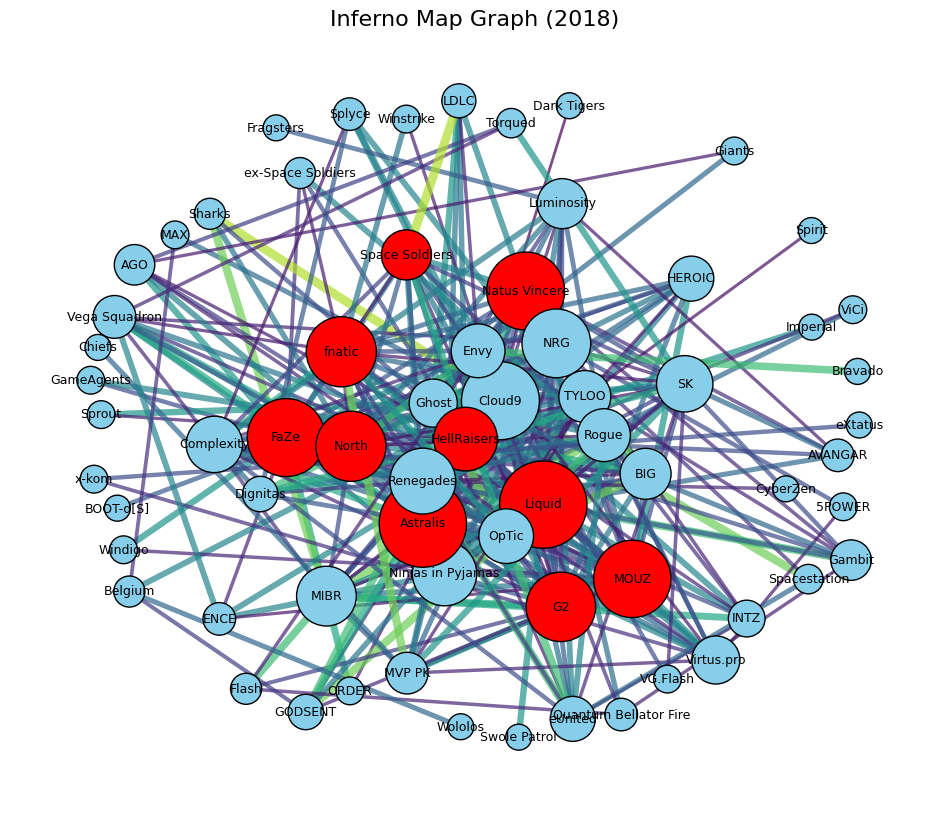

In [21]:
visualize_map_graph(df,2018,"Inferno")